In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import sys
sys.path.append('./..')
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from src import sk_tabnet
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from src.fairness import * 
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from joblib import dump, load
from sklearn.linear_model import LogisticRegression

# Loan Dataset

## Model

In [43]:
np.corrcoef(loan["Target"], loan["CODE_GENDER: M"])

array([[1.        , 0.10149927],
       [0.10149927, 1.        ]])

In [39]:
loan = pd.read_csv("../data/loan/loan_downsampled.csv", index_col = False)
loan.head()

,NAME_CONTRACT_TYPE: Cash loans,NAME_CONTRACT_TYPE: Revolving loans,CODE_GENDER: F,CODE_GENDER: M,CODE_GENDER: XNA,FLAG_OWN_CAR: N,FLAG_OWN_CAR: Y,FLAG_OWN_REALTY: N,FLAG_OWN_REALTY: Y,NAME_TYPE_SUITE: Children,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Target
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,1
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [33]:
model = SVC()

X = loan.drop(['Target'], 1)
# columns = X.columns
# X.columns = range(X.shape[1])
y = loan[['Target']]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 42)
model.fit(train_X, train_y)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [28]:
pred_test_y = model.predict(test_X.values.astype("float"))
accuracy_score(pred_test_y, test_y)

0.6792878433899944

In [29]:
pred_train_y = model.predict(train_X.values.astype("float"))
accuracy_score(pred_train_y, train_y)

0.809651690522867

### Group Fairness

A classifier satisfies
this definition if subjects in both protected and unprotected groups
have equal probability of being assigned to the positive predicted
class. 

P(d =
1|G = m) = P(d = 1|G = f ).

In [34]:
group_fairness(model, test_X, "CODE_GENDER: M", test_y)

Group with CODE_GENDER: M = 0.0 has a probability of positive prediction at 0.6104658749836879
Group with CODE_GENDER: M = 1.0 has a probability of positive prediction at 0.7
The difference is 0.08953412501631208


0.08953412501631208

### Predictive Parity

A classifier satisfies this definition if both protected and unprotected
groups have equal PPV – the probability of a subject with positive predictive value to truly belong to the positive class. 

P(Y = 1|d = 1,G = m) = P(Y = 1|d = 1,G = f )

In [31]:
predictive_parity(model, test_X, "NAME_FAMILY_STATUS: Married", test_y)

Group with NAME_FAMILY_STATUS: Married = 0.0 has a true positive rate of 0.6755218216318786
Group with NAME_FAMILY_STATUS: Married = 1.0 has a true positive rate of 0.674444139445512
The difference is 0.001077682186366613


0.001077682186366613

### Conditional Frequencies
given the model prediction of s the actual probability of T = 1

In [87]:
import numpy as np

In [93]:
np.concatenate([np.array([1,2,3]), np.array([4,5])])

array([1, 2, 3, 4, 5])

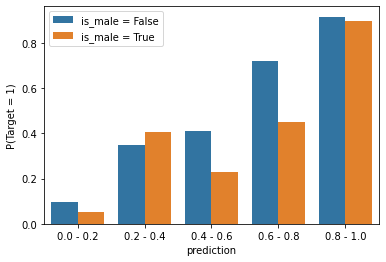

<AxesSubplot:xlabel='prediction', ylabel='P(Target = 1)'>

In [32]:
conditional_frequencies(model, test_X, "is_male", test_y)

### Causal Discrimination

In [105]:
flipped = test_X.copy()

In [102]:
idx_m = test_X["CODE_GENDER: M"] == 1
idx_f = ~(test_X["CODE_GENDER: M"] == 1)

In [35]:
model = sk_tabnet.TNClassifier()
model.load_model("../data/model/loan_tabnet.zip")

Device used : cpu
Device used : cpu


In [110]:
flipped.loc[idx_m,"CODE_GENDER: M"] = 0
flipped.loc[idx_m,"CODE_GENDER: F"] = 1
flipped.loc[idx_f,"CODE_GENDER: M"] = 1
flipped.loc[idx_f,"CODE_GENDER: F"] = 0

In [114]:
causal_discrimination(model, test_X, flipped, "CODE_GENDER: M")

After flipping the sensitve attribute CODE_GENDER: M, 21.0% of the prediction changes
The average prediction of class CODE_GENDER: M = 0.0 changed 0.1119665927182566
The average prediction of class CODE_GENDER: M = 1.0 changed -0.09621052631578947


0.2100217513896721